# Street canyon example [Section VI.B.1]

This example runs a simulation of a street canyon applying two different scattering models on the walls. 

Random-Incidence Scattering Coefficient (RISC) and Bidirectional Scattering Coefficients (BSC) are assessed.

In this example, the models for the corresponding Bidirectional Reflectance Distribution Functions (BRDF) are loaded from local ``.sofa`` files.

*Check example [``App_BRDF_generation.ipynb``](App_BRDF_generation.ipynb) to generate the BRDF files from their corresponding scattering models.*

The output is written in local files and can be visualized in [``VIB_street_canyon_plots.ipynb``](VIB_street_canyon_plots.ipynb).

![alt text](figures/urban_canyon.svg "Illustration of the street canyon")


In [8]:
"""Test the radiosity.Radiosity module."""
import pyfar as pf
import sparrowpy as sp
from utils.run_simu import run_simu, run_simu_BRDF
import numpy as np
import matplotlib.pyplot as plt
import os
from utils.fig_formatting import create_fig

%matplotlib inline

Select origin of scattering (BRDF) data

In [9]:
###################################################
#### SET "True" TO LOAD YOUR OWN GENERATED DATA
#### "False" TO LOAD THE DATA FROM THE PAPER
self_data=False
###################################################

if self_data:
    sub_dir="user"
else:
    sub_dir="paper"

basepath= os.path.join(os.getcwd(),"resources")

We define a function to easily generate the street canyon from 3 dimensions.

In [10]:
def urban_canyon_stub(length_x, length_y, length_z):
    """Create a shoebox room with the given dimensions.

    Parameters
    ----------
    length_x : float
        Length of the urban canyon in meters.
    length_y : float
        width of the urban canyon in meters.
    length_z : float
        height of the urban canyon in meters.

    Returns
    -------
    room : list[geo.Polygon]
        List of the walls of the room.

    """
    return [
        sp.geometry.Polygon(
            [[0, 0, 0], [length_x, 0, 0],
            [length_x, 0, length_z], [0, 0, length_z]],
            [0, 0, 1], [0, 1, 0]),
        sp.geometry.Polygon(
            [[0, 0, 0],[0, length_y, 0],
            [length_x, length_y, 0], [length_x, 0, 0 ]],
            [1, 0, 0], [0, 0, 1]),
        sp.geometry.Polygon(
            [[0, length_y, 0], [length_x, length_y, 0],
            [length_x, length_y, length_z], [0, length_y, length_z]],
            [0, 0, -1], [0, -1, 0]),
        ]

Define basic scene properties

In [11]:
# Define parameters
X = 90
Y = 12
Z = 6

# create geometry
canyon = urban_canyon_stub(X, Y, Z)
source = pf.Coordinates(20, 6, 1)
receiver = pf.Coordinates(21, 6, 2)

Run a very basic scene: this caches optimized functions, ensuring best efficiency for the actual simulations.

In [12]:
run_simu(walls=urban_canyon_stub(1,1,1),
        source=pf.Coordinates(.5,.5,.5),
        receiver=pf.Coordinates(.5,.5,.5),
        patch_size=1)

(TimeData:
 (1, 1) channels with 5 samples,
 [0.004353523254394531,
  0.11275506019592285,
  0.008297443389892578,
  0.0025267601013183594])

## Simulation of urban canyon using RISC and BSC scattering patterns

Simulation settings

**NOTE:** we recommend starting with rougher simulation requirements. With high resolution, simulations may take a long time to simulate.

In [ ]:
max_refl_order=30 # 30 for paper results
ETC_duration=1. # 1. for paper results
ETC_time_step=.002 # .002 for paper results
patch_side_size=3 # 3 for paper results

Run simulation with RISC modeling on walls

In [14]:
BRDF_wall = os.path.join(basepath,sub_dir,"brdf_walls_RISC.sofa")
BRDF_ground = os.path.join(basepath,sub_dir,"brdf_ground.sofa")
etc_RISC=run_simu_BRDF(
    walls=canyon,
    source=source,
    receiver=receiver,
    patch_size=patch_side_size,
    time_step=ETC_time_step,
    duration=ETC_duration,
    refl_order=max_refl_order,
    file_wall=BRDF_wall,
    file_ground=BRDF_ground)



SOFA file contained custom entries
----------------------------------
SourceWeights, ReceiverWeights


SOFA file contained custom entries
----------------------------------
SourceWeights, ReceiverWeights


Run simulation with BSC modeling on walls

In [15]:
BRDF_wall = os.path.join(basepath,sub_dir,"brdf_walls_BSC.sofa")
BRDF_ground = os.path.join(basepath,sub_dir,"brdf_ground.sofa")
etc_BSC=run_simu_BRDF(
    walls=canyon,
    source=source,
    receiver=receiver,
    patch_size=patch_side_size,
    time_step=ETC_time_step,
    duration=ETC_duration,
    refl_order=max_refl_order,
    file_wall=BRDF_wall,
    file_ground=BRDF_ground)

SOFA file contained custom entries
----------------------------------
SourceWeights, ReceiverWeights
SOFA file contained custom entries
----------------------------------
SourceWeights, ReceiverWeights


Write simulation results for access from other files and methods

In [16]:
pf.io.write(os.path.join(basepath,"user",
                         f"ETCs_psize{patch_side_size}.far"),
            compress=False,
            diffuse_etc=etc_RISC,
            custom_etc=etc_BSC,
            freqs=np.array([125, 250, 500, 1e3, 2e3, 4e3]))

Basic figure for quick assessment

(-120.0, 0.0)

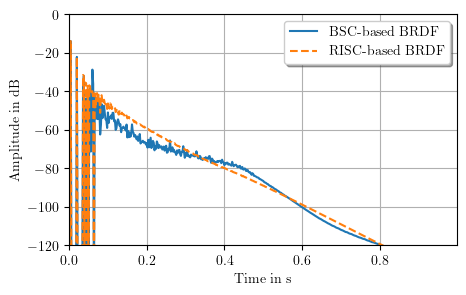

In [17]:
# change this variable to check different frequency bands
freq_bin = 4000
##

i = np.argmin(np.abs(np.array([125, 250, 500, 1e3, 2e3, 4e3])-freq_bin))

f,a=create_fig(figtype="big")
pf.plot.time(etc_BSC[0,i], dB=True, log_prefix=10,
             label=["BSC-based BRDF"],
             linestyle="-")
pf.plot.time(etc_RISC[0,i], dB=True, log_prefix=10,
             label=["RISC-based BRDF"],
             linestyle="--")

plt.legend(fontsize=10,shadow=True)
plt.ylim([-120,0])

In [18]:
%load_ext watermark
%watermark -v -m -iv

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 9.5.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 68 Stepping 1, AuthenticAMD
CPU cores   : 16
Architecture: 64bit

pyfar     : 0.7.3
numpy     : 1.26.4
matplotlib: 3.10.6
sparrowpy : 1.0.0

